# Matrix Factorization for Recommendation Systems

In [1]:
# import libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

from collections import defaultdict #data collector

#Surprise: https://surprise.readthedocs.io/en/stable/
import surprise

from surprise.reader import Reader
from surprise import Dataset, accuracy
from surprise.model_selection import GridSearchCV,PredefinedKFold

##Matrix Factorization Algorithms
from surprise import SVD
from surprise import NMF

In [2]:
np.random.seed(9)

## Import data
source: https://grouplens.org/datasets/movielens/100k/

In [3]:
# The full u data set, 100000 ratings by 943 users on 1682 items.
ratings = pd.read_csv('ml-100k/u.data', sep="\t", names=["userid", "itemid", "rating", "timestamp"])
ratings.head()

,userid,itemid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
# Information about the items (movies)
movie_columns  = ['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL',
                  'unknown','Action','Adventure', 'Animation',"Children's", 'Comedy', 'Crime',
                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                  'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv("ml-100k/u.item",sep="|", encoding='latin-1',names=movie_columns,index_col="movie id",parse_dates=["release date"])
movies.head()

,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Explore the datasets

In [5]:
ratings.describe()

,userid,itemid,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [6]:
rating_user = ratings.groupby(by='userid').count()
print(f"Rating by user: mean {np.round(rating_user['itemid'].mean(),0)} - std {np.round(rating_user['itemid'].std(),0)}")

Rating by user: mean 106.0 - std 101.0


In [7]:
movie_means = ratings.join(movies["movie title"], on="itemid").groupby("movie title").rating.mean()
movie_means = movie_means.sort_values(ascending=False)
movie_means.head(n=20)

movie title
Marlene Dietrich: Shadow and Light (1996)                 5.000000
Prefontaine (1997)                                        5.000000
Santa with Muscles (1996)                                 5.000000
Star Kid (1997)                                           5.000000
Someone Else's America (1995)                             5.000000
Entertaining Angels: The Dorothy Day Story (1996)         5.000000
Saint of Fort Washington, The (1993)                      5.000000
Great Day in Harlem, A (1994)                             5.000000
They Made Me a Criminal (1939)                            5.000000
Aiqing wansui (1994)                                      5.000000
Pather Panchali (1955)                                    4.625000
Anna (1996)                                               4.500000
Everest (1998)                                            4.500000
Maya Lin: A Strong Clear Vision (1994)                    4.500000
Some Mother's Son (1996)                          

#### Plots

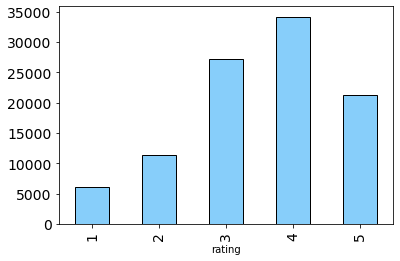

In [8]:
# Histogram of ratings
fig = ratings.groupby("rating").size().plot(kind="bar",color = 'lightskyblue',edgecolor='black',fontsize=14)

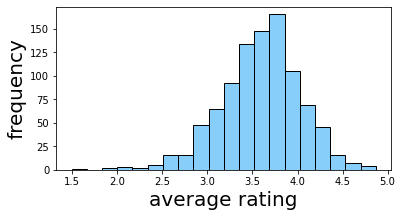

In [9]:
# Histogram of average ratings by user
user_means = ratings.groupby("userid").rating.mean().sort_values()
plt.figure(figsize=(6,3))
plt.hist(user_means,bins=20,color = 'lightskyblue',edgecolor='black')
plt.xlabel('average rating',fontsize=20)
plt.ylabel('frequency',fontsize=20)
plt.show()

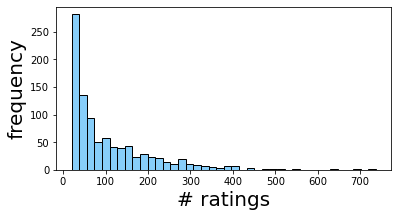

In [10]:
# Histogram of number of ratings by user
user_activity = ratings.groupby("userid").size().sort_values()
plt.figure(figsize=(6,3))
plt.hist(user_activity,bins=40,color = 'lightskyblue',edgecolor='black')
plt.xlabel('# ratings',fontsize=20)
plt.ylabel('frequency',fontsize=20)
plt.show()

#### Create R matrix: user x items

In [11]:
rating_matrix = ratings.pivot(index="userid", columns="itemid", values="rating").values
rating_matrix

array([[ 5.,  3.,  4., ..., nan, nan, nan],
       [ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 5., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  5., nan, ..., nan, nan, nan]])

In [12]:
# remove nan values
nan_mask = np.isnan(rating_matrix)
rating_matrix[nan_mask] = 0
rating_matrix

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

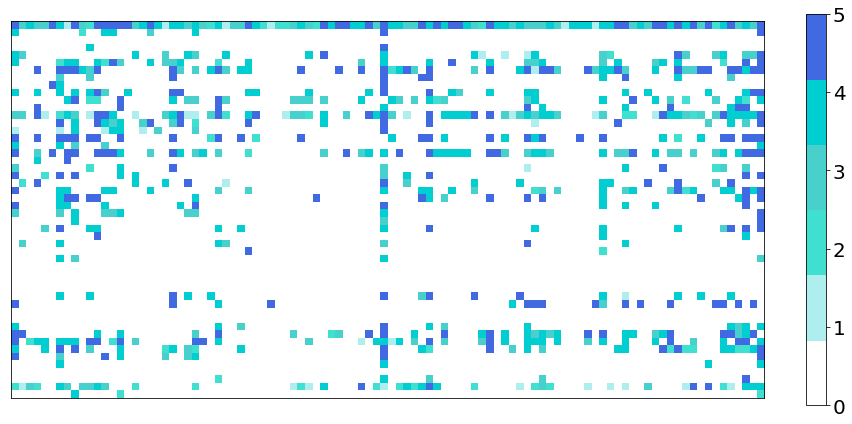

In [13]:
# snap of the rating matrix
maxA = int(np.max(rating_matrix))
cmap1 = ListedColormap(['white', 'paleturquoise','turquoise',  'mediumturquoise','darkturquoise', 'royalblue'][:maxA+1])

plt.figure(figsize=(12,6))
plt.imshow(rating_matrix[:50,:100],cmap=cmap1)
cb = plt.colorbar(fraction=0.046, ticks=list(np.arange(maxA+1)))
cb.ax.tick_params(labelsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = plt.gca()
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.tight_layout()

## Model with surprise package

In [14]:
# path to dataset folder
files_dir = os.path.expanduser('./ml-100k/')

# this time, we'll use the built-in reader.
reader = Reader('ml-100k')

### GridsearchCV to choose the best number of factors

This depends on the model and the measure we use.

In [15]:
data_full = Dataset.load_from_file('ml-100k/u.data', reader=reader)
data_full

In [16]:
param_grid = {'n_factors': [5,7,9,11,14,16,18,20]}
gs = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=5)
gs.fit(data_full)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9651656272335192
{'n_factors': 16}


In [17]:
param_grid = {'n_factors': [5,7,9,11,14,16,18,20]}
gs = GridSearchCV(NMF, param_grid, measures=['mae'], cv=5)
gs.fit(data_full)

# best RMSE score
print(gs.best_score['mae'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['mae'])

0.7535827612280338
{'n_factors': 20}


In [18]:
param_grid = {'n_factors': [5,7,9,11,14,16,18,20]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data_full)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9354657867418199
{'n_factors': 16}


### Cross Validation to choose the best model among SVD, SVD biased, NMF, and NMF biased

In [19]:
# Let's fix 
K = 16
maxit = 20

In [20]:
# folds_files is a list of tuples containing file paths:
# [(u1.base, u1.test), (u2.base, u2.test), ... (u5.base, u5.test)]
train_file = files_dir + 'u%d.base'
test_file = files_dir + 'u%d.test'
folds_files = [(train_file % i, test_file % i) for i in (1, 2, 3, 4, 5)]

data = Dataset.load_from_folds(folds_files, reader=reader)
pkf = PredefinedKFold()

In [21]:
RMSE = {}
MAE = {}

##### Using `SVD`

In [22]:
algo = SVD(biased=False,n_factors=K,n_epochs=maxit)
RMSE['SVD'] = []
MAE['SVD'] = []
for trainset, testset in pkf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error and Mean Absolute Error
    RMSE['SVD'].append(accuracy.rmse(predictions, verbose=True))
    MAE['SVD'].append(accuracy.mae(predictions, verbose=True))

RMSE: 0.9549
MAE:  0.7491
RMSE: 0.9449
MAE:  0.7398
RMSE: 0.9416
MAE:  0.7407
RMSE: 0.9421
MAE:  0.7413
RMSE: 0.9431
MAE:  0.7439


##### Using `SVD biased`

In [23]:
algo = SVD(biased=True,n_factors=K,n_epochs=maxit)
RMSE['SVDbiased'] = []
MAE['SVDbiased'] = []
for trainset, testset in pkf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error and Mean Absolute Error
    RMSE['SVDbiased'].append(accuracy.rmse(predictions, verbose=True))
    MAE['SVDbiased'].append(accuracy.mae(predictions, verbose=True))

RMSE: 0.9511
MAE:  0.7500
RMSE: 0.9427
MAE:  0.7407
RMSE: 0.9337
MAE:  0.7359
RMSE: 0.9321
MAE:  0.7349
RMSE: 0.9299
MAE:  0.7365


##### Using `NMF`

In [24]:
algo = NMF(biased=False,n_factors=K,n_epochs=maxit)
RMSE['NMF'] = []
MAE['NMF'] = []
for trainset, testset in pkf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error and Mean Absolute Error
    RMSE['NMF'].append(accuracy.rmse(predictions, verbose=True))
    MAE['NMF'].append(accuracy.mae(predictions, verbose=True))

RMSE: 1.0115
MAE:  0.7789
RMSE: 1.0042
MAE:  0.7718
RMSE: 0.9868
MAE:  0.7623
RMSE: 0.9838
MAE:  0.7612
RMSE: 0.9885
MAE:  0.7696


##### Using `NMF biased`

In [25]:
algo = NMF(biased=True,n_factors=K,n_epochs=maxit)
RMSE['NMFbiased'] = []
MAE['NMFbiased'] = []
for trainset, testset in pkf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error and Mean Absolute Error
    RMSE['NMFbiased'].append(accuracy.rmse(predictions, verbose=True))
    MAE['NMFbiased'].append(accuracy.mae(predictions, verbose=True))

RMSE: 0.9531
MAE:  0.7518
RMSE: 0.9454
MAE:  0.7446
RMSE: 0.9402
MAE:  0.7433
RMSE: 1.2572
MAE:  0.9730
RMSE: 0.9381
MAE:  0.7467


Let's see the results

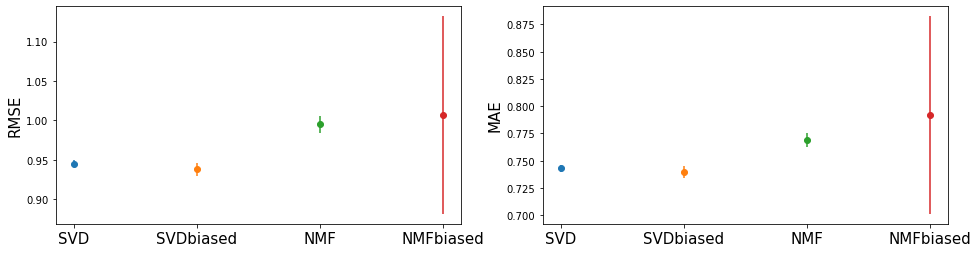

In [26]:
fig, ax = plt.subplots(1,2,figsize=(16,4))

for i,k in enumerate(RMSE.keys()):
    ax[0].scatter(i,np.mean(RMSE[k]),label=k)
    ax[0].errorbar(i,np.mean(RMSE[k]),yerr= np.std(RMSE[k]))
    ax[1].scatter(i,np.mean(MAE[k]),label=k)
    ax[1].errorbar(i,np.mean(MAE[k]),yerr= np.std(MAE[k]))
ax[0].set_xticks([0.0, 1.0, 2., 3.0])
ax[0].set_xticklabels(RMSE.keys(), fontsize=15)
ax[0].set_ylabel('RMSE', fontsize=15)
ax[1].set_xticks([0.0, 1.0, 2., 3.0])
ax[1].set_xticklabels(RMSE.keys(), fontsize=15)
ax[1].set_ylabel('MAE', fontsize=15)

plt.show()

We choose the model with the lowest values (lower measures -> better performance)

### Make predictions and recommendations

In [27]:
trainset = data_full.build_full_trainset()
best_algo = SVD(biased=True,n_factors=K,n_epochs=maxit)
best_algo.fit(trainset)

testset = trainset.build_anti_testset()
predictions = best_algo.test(testset)

In [28]:
predictions[:2]

[Prediction(uid='196', iid='302', r_ui=3.52986, est=4.135342318889117, details={'was_impossible': False}),
 Prediction(uid='196', iid='377', r_ui=3.52986, est=2.656302953872085, details={'was_impossible': False})]

In [29]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [30]:
top_n = get_top_n(predictions, n=5)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

196 ['408', '64', '169', '318', '483']
186 ['64', '318', '408', '483', '114']
22 ['318', '272', '12', '251', '178']
244 ['408', '483', '474', '480', '178']
166 ['64', '114', '12', '408', '318']
298 ['408', '169', '64', '114', '480']
115 ['169', '408', '135', '474', '603']
253 ['408', '603', '515', '114', '169']
305 ['114', '515', '513', '603', '641']
6 ['603', '179', '641', '657', '114']
62 ['169', '408', '272', '178', '185']
286 ['114', '515', '603', '12', '170']
200 ['408', '64', '603', '251', '480']
210 ['318', '408', '64', '169', '474']
224 ['64', '174', '408', '190', '79']
303 ['169', '511', '178', '285', '192']
122 ['408', '169', '114', '603', '483']
194 ['408', '169', '114', '313', '285']
291 ['318', '483', '357', '178', '408']
234 ['408', '169', '114', '272', '302']
119 ['408', '318', '515', '190', '170']
167 ['64', '22', '174', '483', '408']
299 ['64', '178', '357', '963', '427']
308 ['114', '173', '190', '272', '474']
95 ['272', '12', '318', '114', '408']
38 ['408', '64', '19

867 ['408', '169', '178', '114', '513']
861 ['318', '515', '12', '408', '64']
870 ['408', '515', '114', '251', '285']
871 ['64', '318', '408', '169', '483']
875 ['408', '515', '483', '178', '318']
876 ['408', '169', '64', '357', '483']
872 ['318', '408', '64', '169', '603']
866 ['318', '64', '408', '483', '114']
877 ['408', '169', '483', '64', '12']
873 ['64', '408', '318', '12', '114']
880 ['169', '408', '114', '483', '513']
878 ['408', '169', '483', '178', '134']
869 ['169', '408', '114', '483', '357']
881 ['408', '313', '169', '496', '603']
879 ['318', '408', '483', '174', '603']
883 ['169', '114', '641', '178', '923']
882 ['408', '318', '64', '169', '603']
884 ['408', '483', '318', '64', '178']
886 ['511', '169', '190', '313', '285']
885 ['408', '515', '496', '313', '64']
889 ['272', '313', '114', '285', '963']
874 ['408', '318', '64', '483', '603']
892 ['408', '169', '114', '272', '474']
890 ['408', '169', '318', '64', '513']
893 ['64', '318', '408', '169', '12']
887 ['484', '169'

Let's get the name of the recommended movies

In [31]:
top_n_user_movie = {}
for uid, user_ratings in top_n.items():
    top_n_user_movie[uid] = [list(movies[movies.index==int(iid)]['movie title'])[0] for (iid, _) in user_ratings]

In [32]:
recommendations = pd.DataFrame.from_dict(top_n_user_movie, orient='index')
recommendations.head()

,0,1,2,3,4
196,"Close Shave, A (1995)","Shawshank Redemption, The (1994)","Wrong Trousers, The (1993)",Schindler's List (1993),Casablanca (1942)
186,"Shawshank Redemption, The (1994)",Schindler's List (1993),"Close Shave, A (1995)",Casablanca (1942),Wallace & Gromit: The Best of Aardman Animatio...
22,Schindler's List (1993),Good Will Hunting (1997),"Usual Suspects, The (1995)",Shall We Dance? (1996),12 Angry Men (1957)
244,"Close Shave, A (1995)",Casablanca (1942),Dr. Strangelove or: How I Learned to Stop Worr...,North by Northwest (1959),12 Angry Men (1957)
166,"Shawshank Redemption, The (1994)",Wallace & Gromit: The Best of Aardman Animatio...,"Usual Suspects, The (1995)","Close Shave, A (1995)",Schindler's List (1993)


In [33]:
recommendations.iloc[:,0].value_counts()

Close Shave, A (1995)                                                          374
Schindler's List (1993)                                                        131
Wrong Trousers, The (1993)                                                     113
Shawshank Redemption, The (1994)                                                88
Rear Window (1954)                                                              32
Casablanca (1942)                                                               29
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)     20
Usual Suspects, The (1995)                                                      19
Raiders of the Lost Ark (1981)                                                  17
Wallace & Gromit: The Best of Aardman Animation (1996)                          17
Kolya (1996)                                                                    11
Godfather, The (1972)                                                           10
Good

In [34]:
recommendations.apply(lambda x: x.value_counts())

,0,1,2,3,4
12 Angry Men (1957),7.0,21.0,33.0,49.0,80.0
2001: A Space Odyssey (1968),NaN,NaN,1.0,NaN,NaN
"African Queen, The (1951)",NaN,NaN,1.0,2.0,2.0
Air Force One (1997),1.0,1.0,NaN,NaN,2.0
Aladdin (1992),NaN,NaN,NaN,2.0,NaN
...,...,...,...,...,...
"Usual Suspects, The (1995)",19.0,31.0,57.0,51.0,59.0
Vertigo (1958),NaN,1.0,3.0,1.0,5.0
Wallace & Gromit: The Best of Aardman Animation (1996),17.0,37.0,75.0,81.0,73.0
Wings of Desire (1987),3.0,NaN,1.0,NaN,2.0


#### Given an user and a movie

In [35]:
uid = str(196)  # raw user id (as in the ratings file). They are **strings**!
iid = str(242)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = best_algo.predict(uid, iid, r_ui=3, verbose=True)
pred

user: 196        item: 242        r_ui = 3.00   est = 3.81   {'was_impossible': False}


Prediction(uid='196', iid='242', r_ui=3, est=3.8065844631876793, details={'was_impossible': False})